# Modelagem

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)

import warnings

# remoção segura para deixar o log mais limpo
warnings.filterwarnings("ignore", message="X does not have valid feature names") 

## Pré-processamento dos dados para o modelo 

Leitura do dataset de features e covertendo os tipos dos dados

In [17]:
# Leitura do dataset
dataset_features_v1 = pd.read_csv('../data/processed/dataset_features_v1.csv')

# Conversão dos tipos numéricos e categóricos
dataset_features_v1 = dataset_features_v1.astype({
    'ID_CLIENTE': 'int64',
    'VALOR_A_PAGAR': 'float64',
    'TAXA': 'float64',
    'RENDA_MES_ANTERIOR': 'float64',
    'NO_FUNCIONARIOS': 'int64',
    'FLAG_PF': 'int64',
    'DIAS_ATRASO': 'int64',
    'TARGET_INADIMPLENCIA': 'int64',
    'DIAS_ADIANTAMENTO': 'int64',
    'TEMPO_DE_CASA_MESES': 'int64',
    'PRAZO_PAGAMENTO_DIAS': 'int64',
    'MES_SAFRA': 'int32',
    'INADIMPLENCIAS_ANTERIORES': 'int64',
    'SEGMENTO_INDUSTRIAL': 'category',
    'DOMINIO_EMAIL': 'category',
    'PORTE': 'category',
    'CEP_2_DIG': 'category',
})

# Conversão de datas
dataset_features_v1['SAFRA_REF'] = pd.to_datetime(
    dataset_features_v1['SAFRA_REF'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_EMISSAO_DOCUMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_PAGAMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_PAGAMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_VENCIMENTO'] = pd.to_datetime(
    dataset_features_v1['DATA_VENCIMENTO'], format='%Y-%m-%d', errors='coerce'
)

dataset_features_v1['DATA_CADASTRO'] = pd.to_datetime(
    dataset_features_v1['DATA_CADASTRO'], format='%Y-%m-%d', errors='coerce'
)


In [18]:
dataset_features_v1.dtypes

ID_CLIENTE                            int64
SAFRA_REF                    datetime64[ns]
DATA_EMISSAO_DOCUMENTO       datetime64[ns]
DATA_PAGAMENTO               datetime64[ns]
DATA_VENCIMENTO              datetime64[ns]
VALOR_A_PAGAR                       float64
TAXA                                float64
RENDA_MES_ANTERIOR                  float64
NO_FUNCIONARIOS                       int64
DATA_CADASTRO                datetime64[ns]
FLAG_PF                               int64
SEGMENTO_INDUSTRIAL                category
DOMINIO_EMAIL                      category
PORTE                              category
CEP_2_DIG                          category
DIAS_ATRASO                           int64
TARGET_INADIMPLENCIA                  int64
DIAS_ADIANTAMENTO                     int64
TEMPO_DE_CASA_MESES                   int64
PRAZO_PAGAMENTO_DIAS                  int64
MES_SAFRA                             int32
INADIMPLENCIAS_ANTERIORES             int64
ADIANTAMENTOS_ANTERIORES        

#### Remoção de colunas irrelevantes

Comecei eliminando colunas que não agregam valor ao modelo.

* **ID_CLIENTE** é apenas um identificador único, não possui utilidade preditiva.
* As colunas de datas brutas (**DATA_EMISSAO_DOCUMENTO**, **DATA_PAGAMENTO**, **DATA_VENCIMENTO**, **DATA_CADASTRO** e **SAFRA_REF**) foram removidas porque já foram utilizadas para criar variáveis derivadas mais informativas.

#### Prevenção de data leakage

* As variáveis **DIAS_ATRASO** e **DIAS_ADIANTAMENTO** foram retiradas porque só estariam disponíveis após o vencimento, ou seja, depois da ocorrência ou não da inadimplência.
* Manter essas colunas geraria vazamento de informação (data leakage), prejudicando a generalização do modelo e provocando overfitting.

#### Codificação de variáveis categóricas

* As variáveis **SEGMENTO_INDUSTRIAL**, **PORTE** e **DOMINIO_EMAIL**, por serem categóricas com baixa cardinalidade, foram tratadas com One-Hot Encoding.
* Já a variável **CEP_2_DIG** apresenta alta cardinalidade, e por isso utilizei Frequency Encoding, uma técnica que substitui cada categoria pela frequência relativa com que aparece na base de dados. Isso evita a explosão de colunas sem perder a representatividade da variável.

#### Separação dos dados

* Após o pré-processamento, separei as variáveis explicativas (**X**) da variável alvo (**TARGET_INADIMPLENCIA**).
* Em seguida, fiz a divisão entre treino e teste com **train_test_split**, utilizando **stratify=y** para garantir a mesma proporção de inadimplentes em ambas as amostras.


In [19]:
# Eliminar colunas irrelevantes
cols_drop = [
    'ID_CLIENTE', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
    'DATA_VENCIMENTO', 'DATA_CADASTRO', 'SAFRA_REF',
    'DIAS_ATRASO', 'DIAS_ADIANTAMENTO', # Colunas que só são conhecidas depois do treinamento. São removidas para evitar data leakage
]

df = dataset_features_v1.drop(columns=cols_drop)

# Aplicando One-Hot Encoding em variáveis categóricas de baixa cardinalidade
df = pd.get_dummies(df, columns=['SEGMENTO_INDUSTRIAL', 'PORTE', 'DOMINIO_EMAIL'], drop_first=True)

# Aplicando Frequency Encoding para variável com alta cardinalidade 
freq_map = df['CEP_2_DIG'].value_counts(normalize=True)
df['CEP_2_DIG'] = df['CEP_2_DIG'].map(freq_map)

# Importante não adionar a variável target, resultaria em data leackage e consequentemente overfitting
X = df.drop(columns='TARGET_INADIMPLENCIA')
y = df['TARGET_INADIMPLENCIA']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Escolhendo o modelo preditor e seus parâmetros (Cross Validation e GridSearch)


Aqui realizo a comparação entre diferentes algoritmos de classificação — **XGBoost**, **Random Forest**, **Regressão Logística** e **LightGBM**

Para cada modelo:

* É definida uma grade de hiperparâmetros (parâmetros comumente observados em problemas de crédito e inadimplência em outros trabalhos)
* Aplica-se validação cruzada estratificada com 5 divisões, utilizando GridSearchCV.
* A métrica utilizada para otimização é o **ROC AUC**.

O pipeline inclui os seguintes passos:

1. **Padronização dos dados** com **StandardScaler**.
2. **Balanceamento das classes** com **SMOTE**, para lidar com o desbalanceamento da variável alvo.
3. **Treinamento e avaliação** de cada modelo com base nos melhores hiperparâmetros encontrados.

Ao final, são calculadas as principais métricas no conjunto de teste:

* ROC AUC
* Relatório de classificação (precision, recall e F1-score)
* Matriz de confusão

Os resultados finais são salvos em um arquivo **.pkl** para facilitar a análise posterior.

In [20]:
# Parâmetros
modelos_parametros = {
    "XGBoost": (
        XGBClassifier(
            #use_label_encoder=False,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ),
        {
            "clf__n_estimators": [200, 300, 400],
            "clf__max_depth": [7, 10],
            "clf__learning_rate": [0.01, 0.1],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8],
            "clf__gamma": [0, 1],  
            "clf__min_child_weight": [1, 5],
            "clf__reg_alpha": [0, 0.5],    # L1 regularização (sem e com força moderada)
            "clf__reg_lambda": [1, 2.0],   # L2 regularização (default e valor mais forte)
        }
    ),
    
    "RandomForest": (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            "clf__n_estimators": [100, 200, 300],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4],
            "clf__max_features": ['sqrt', 'log2'],  # diversificação
            "clf__bootstrap": [True, False]
        }
    ),

    "LogisticRegression": (
        LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42),
        {
            "clf__C": [0.1, 1.0, 10.0, 100.0]
        }
    ),

    "LightGBM": (
        LGBMClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__num_leaves": [31, 50, 100],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__min_child_samples": [10, 20, 50],
            "clf__subsample": [0.6, 0.8, 1.0],
            "clf__colsample_bytree": [0.6, 0.8, 1.0]
        }
    )
}

# Validação cruzada e execução 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados = {}


# *****************************************************************
# ATENÇÃO: Este bloco foi comentado porque realiza o GridSearchCV,
# que demanda muito tempo de processamento. Os melhores parâmetros
# já foram definidos e estão aplicados logo abaixo no treino do 
# Random Forest com todos os dados. 
# A reprodução do modelo abaixo costuma ser rápida.
# *****************************************************************




'''

for nome, (modelo, grid_params) in modelos_parametros.items():
    print(f"\nTreinando: {nome}")
    pipeline = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("smote", SMOTE(random_state=42)),
        ("clf", modelo)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=grid_params,
        cv=cv,
        scoring="roc_auc",
        #verbose=3,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    resultados[nome] = {
        "Melhores parâmetros": grid.best_params_,
        "ROC AUC (validação)": grid.best_score_,
        "ROC AUC (teste)": roc_auc_score(y_test, y_proba),
        "Classification Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()
    }


# Salva resultados Grid Search CV
with open("../data/processed/resultados_grid_search_cv_v6.pkl", "wb") as f:
    pickle.dump(resultados, f)

'''

'\n\nfor nome, (modelo, grid_params) in modelos_parametros.items():\n    print(f"\nTreinando: {nome}")\n    pipeline = Pipeline(steps=[\n        ("scaler", StandardScaler()),\n        ("smote", SMOTE(random_state=42)),\n        ("clf", modelo)\n    ])\n\n    grid = GridSearchCV(\n        pipeline,\n        param_grid=grid_params,\n        cv=cv,\n        scoring="roc_auc",\n        #verbose=3,\n        n_jobs=-1\n    )\n\n    grid.fit(X_train, y_train)\n\n    best_model = grid.best_estimator_\n    y_pred = best_model.predict(X_test)\n    y_proba = best_model.predict_proba(X_test)[:, 1]\n\n    resultados[nome] = {\n        "Melhores parâmetros": grid.best_params_,\n        "ROC AUC (validação)": grid.best_score_,\n        "ROC AUC (teste)": roc_auc_score(y_test, y_proba),\n        "Classification Report": classification_report(y_test, y_pred, output_dict=True),\n        "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist()\n    }\n\n\n# Salva resultados Grid Search CV\nwith open

O melhor modelo para o problema é o **Random Forest**. Isso se justifica pelos seus resultados equilibrados entre desempenho preditivo e estabilidade. Apesar de outros modelos como o XGBoost também apresentarem boas métricas, o Random Forest obteve a **maior ROC AUC no conjunto de teste (0.9621)**, o que indica uma excelente capacidade de discriminar entre clientes inadimplentes e adimplentes. Além disso, seu desempenho na **classe minoritária (inadimplentes)** foi sólido, com um **F1-score de 0.72** e **recall de 0.75**, demonstrando boa sensibilidade para identificar casos positivos, ponto crítico em cenários de risco de crédito. O modelo apresentou um ótimo equilíbrio entre **precisão e recall**, sem exigir parametrizações muito sensíveis como outros modelos baseados em boosting. Esses fatores tornam o Random Forest uma escolha confiável para o problema proposto.

In [21]:
# *********************************************************************************
# ATENÇÃO: Este bloco foi comentado porque representa o resultado do GridSearchCV,
# que demanda muito tempo de processamento. Os melhores parâmetros
# já foram definidos e estão aplicados logo abaixo no treino do 
# Random Forest com todos os dados. 
# A reprodução do modelo abaixo costuma ser rápida.
# **********************************************************************************



'''
# Resultados Finais 
for nome, res in resultados.items():
    print(f"\n=== {nome} ===")
    print("Melhores parâmetros:", res["Melhores parâmetros"])
    print("ROC AUC (validação):", round(res["ROC AUC (validação)"], 4))
    print("ROC AUC (teste):", round(res["ROC AUC (teste)"], 4))
    print("Classification Report:")
    print(pd.DataFrame(res["Classification Report"]).T)
    print("Confusion Matrix:")
    print(np.array(res["Confusion Matrix"]))
    #plotando a matriz de confusão 
    cm = np.array(res["Confusion Matrix"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="plasma", values_format="d")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()
'''

'\n# Resultados Finais \nfor nome, res in resultados.items():\n    print(f"\n=== {nome} ===")\n    print("Melhores parâmetros:", res["Melhores parâmetros"])\n    print("ROC AUC (validação):", round(res["ROC AUC (validação)"], 4))\n    print("ROC AUC (teste):", round(res["ROC AUC (teste)"], 4))\n    print("Classification Report:")\n    print(pd.DataFrame(res["Classification Report"]).T)\n    print("Confusion Matrix:")\n    print(np.array(res["Confusion Matrix"]))\n    #plotando a matriz de confusão \n    cm = np.array(res["Confusion Matrix"])\n    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])\n    disp.plot(cmap="plasma", values_format="d")\n    plt.title(f"Matriz de Confusão - {nome}")\n    plt.show()\n'

## HOLD OUT (X_train, X_test)


=== Treinamento em hold-out com o modelo escolhido ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished



=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9808    0.9731    0.9769     13675
           1     0.6913    0.7601    0.7241      1084

    accuracy                         0.9574     14759
   macro avg     0.8361    0.8666    0.8505     14759
weighted avg     0.9596    0.9574    0.9584     14759

ROC AUC (teste): 0.9621


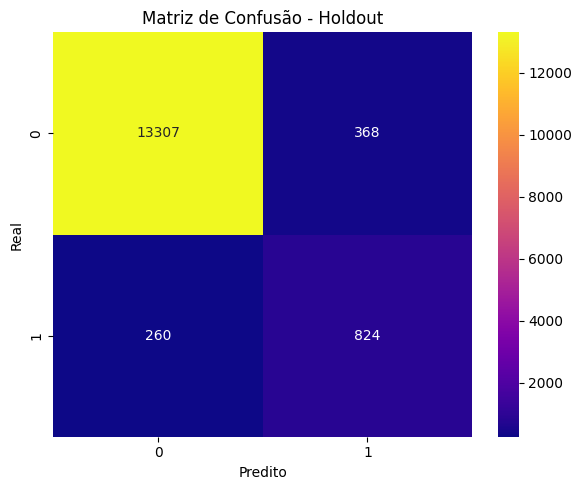

In [22]:
# === Hiperparâmetros ótimos para Random Forest ===
melhores_params = {
     'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 300,
     'random_state': 42,
     'n_jobs': -1,
     'verbose': 1  # ativa logs do Random Forest durante o fit
 }

# === Pipeline com SMOTE + Escalonamento + Random Forest ===
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(**melhores_params))
])

# === Treinamento com o conjunto treino ===
print("\n=== Treinamento em hold-out com o modelo escolhido ===")
pipeline.fit(X_train, y_train)

# === Predição no holdout ===
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# === Métricas ===
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC AUC (teste): {roc_auc:.4f}")

# === Matriz de Confusão ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='plasma', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Holdout")
plt.tight_layout()
plt.show()

# === Barplot com principais métricas ===
metrics_dict = {
    "ROC AUC": roc_auc,
    "Acurácia": accuracy_score(y_test, y_pred),
    "Precisão (Classe 1)": precision_score(y_test, y_pred),
    "Recall (Classe 1)": recall_score(y_test, y_pred),
    "F1-Score (Classe 1)": f1_score(y_test, y_pred),
    "F1 Macro": report["macro avg"]["f1-score"],
    "F1 Weighted": report["weighted avg"]["f1-score"],
    "Classification_report": classification_report(y_test, y_pred, digits=4),
    "Confusion Matrix": confusion_matrix(y_test, y_pred),
}

# === Salvar dados de treinamento ===
with open('../data/processed/resultados_holdout_random_forest.pkl', 'wb') as f:
    pickle.dump(metrics_dict, f)

## Treinamento final do modelo com todos os dados 

In [23]:
print("\n=== Treinamento final do modelo escolhido com todos os dados ===")
pipeline.fit(X, y)

# === Salvar modelo treinado ===
with open('../data/processed/final_random_forest_structure.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Modelo salvo em '../data/processed/final_random_forest_structure.pkl'")


=== Treinamento final do modelo escolhido com todos os dados ===


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   24.3s finished


Modelo salvo em '../data/processed/final_random_forest_structure.pkl'


In [24]:
# Caminho para o arquivo .pkl
caminho_arquivo = '../data/processed/resultados_grid_search_cv_v6.pkl'

# Abrindo o arquivo pickle
with open(caminho_arquivo, 'rb') as f:
    objeto = pickle.load(f)


objeto

{'XGBoost': {'Melhores parâmetros': {'clf__colsample_bytree': 0.6,
   'clf__gamma': 0,
   'clf__learning_rate': 0.1,
   'clf__max_depth': 10,
   'clf__min_child_weight': 1,
   'clf__n_estimators': 300,
   'clf__reg_alpha': 0,
   'clf__reg_lambda': 2.0,
   'clf__subsample': 0.8},
  'ROC AUC (validação)': 0.9619501117431108,
  'ROC AUC (teste)': 0.9587022133475448,
  'Classification Report': {'0': {'precision': 0.9762909090909091,
    'recall': 0.9816453382084095,
    'f1-score': 0.9789608021877849,
    'support': 13675.0},
   '1': {'precision': 0.7512388503468781,
    'recall': 0.6992619926199262,
    'f1-score': 0.7243191591017678,
    'support': 1084.0},
   'accuracy': 0.960905210380107,
   'macro avg': {'precision': 0.8637648797188936,
    'recall': 0.8404536654141679,
    'f1-score': 0.8516399806447763,
    'support': 14759.0},
   'weighted avg': {'precision': 0.9597615756890167,
    'recall': 0.960905210380107,
    'f1-score': 0.9602582111514517,
    'support': 14759.0}},
  'Confus